In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import rmspe

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train['pred'] = train.groupby('stock_id')['target'].transform('mean')

In [4]:
rmspe(train['target'], train['pred'] * 0.5)

0.4858051350968168

In [5]:
import os
import re
stock_ids = sorted(
    [int(re.sub('stock_id=', '', x)) for x in os.listdir('book_train.parquet')])

In [26]:
stock_id = stock_ids[4]

In [38]:
book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
trades = pd.read_parquet('trade_train.parquet/stock_id=' + str(stock_id))

In [39]:
book = book.merge(trades, how='left', on=['time_id', 'seconds_in_bucket'])

In [40]:
book[book.time_id == 5].head(100).tail(15)

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,price,size,order_count
85,5,120,1.003335,1.004126,1.002608,1.004142,307,14,22,123,NaN,NaN,NaN
86,5,121,1.003335,1.004142,1.003206,1.004255,361,109,22,1,1.003739,3.0,1.0
87,5,122,1.003335,1.004142,1.003222,1.004255,361,109,50,1,NaN,NaN,NaN
88,5,123,1.003335,1.004142,1.002608,1.004255,360,109,22,1,1.003577,418.0,5.0
89,5,125,1.002608,1.004126,1.001865,1.004142,22,101,25,209,1.003335,300.0,2.0
90,5,127,1.002608,1.004110,1.001865,1.004126,22,116,25,101,NaN,NaN,NaN
91,5,128,1.002608,1.004110,1.001865,1.004126,22,219,25,1,NaN,NaN,NaN
92,5,129,1.002608,1.004110,1.001865,1.004142,22,220,25,109,NaN,NaN,NaN
93,5,132,1.002883,1.004110,1.002608,1.004142,1,226,22,109,NaN,NaN,NaN
94,5,133,1.002883,1.004110,1.002608,1.004142,1,229,22,109,NaN,NaN,NaN


In [41]:
book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
book['log_price'] = np.log(book['wap'])
book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
book['square_return'] = book['log_return'] ** 2
book = book[~book['log_return'].isnull()]
book['stock_id'] = stock_id

In [15]:
book['bid_price1'].value_counts()

1.000000    5509
1.000024     337
1.000024     331
1.000023     325
1.000023     320
            ... 
0.993176       1
1.002979       1
0.993167       1
1.002961       1
0.997368       1
Name: bid_price1, Length: 81633, dtype: int64

In [17]:
book['ask_price1'].value_counts()

1.000000    5839
1.000024     468
1.000024     345
1.000024     308
1.000026     296
            ... 
1.004353       1
1.004351       1
1.022372       1
1.004369       1
0.996977       1
Name: ask_price1, Length: 77354, dtype: int64

In [35]:
def book_filler(book):
    collect_data = []
    for time_id, time_id_data in book.groupby('time_id'):
        time_id_data = pd.merge(time_id_data, pd.DataFrame({'seconds_in_bucket': range(0, 600)}), 
                               on='seconds_in_bucket', how='right')
        time_id_data['time_id'] = time_id

        collect_data.append(time_id_data.sort_values('seconds_in_bucket'))
    
    return pd.concat(collect_data)

In [51]:
book1 = book_filler(book)
book1['square_return'] = book1['square_return'].fillna(0)
book1 = book1.reset_index().drop(columns='index')

In [67]:
temp = book1.groupby('time_id')['square_return'].expanding().sum().reset_index().drop(columns='level_1') 

In [70]:
temp['square_return'] = (temp['square_return']) ** 0.5

In [55]:
temp = temp.dropna()

In [63]:
temp['time_id'].unique()

array([    5,    11,    16, ..., 32758, 32763, 32767])

<AxesSubplot:>

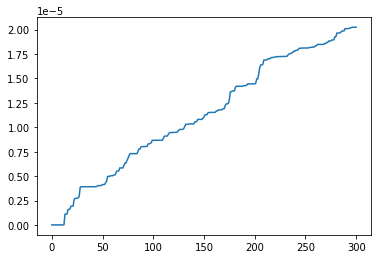

In [75]:
book.square_return[book.time_id == 5].cumsum().plot()

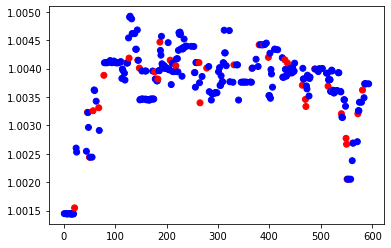

In [110]:
dots = book['size'].fillna(0)[book.time_id == 5]

color = [{True: 'red', False: 'blue'}[x] for x in dots > 0]

plt.scatter(book['seconds_in_bucket'][book.time_id == 5], book['wap'][book.time_id == 5], color=color)

<AxesSubplot:>

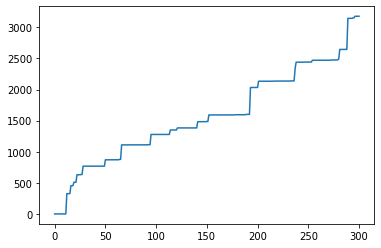

In [87]:
book['size_x'][book.time_id == 5].fillna(0).cumsum().plot()

In [9]:
temp = book.groupby(['time_id', 'stock_id'])['square_return', 'size'].sum().reset_index()
temp['answer'] = temp['square_return'] ** 0.5

/home/dro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [10]:
merged = pd.merge(train, temp, on=['time_id', 'stock_id'], how='right')

In [11]:
merged['to_group'] = merged['answer'] - merged['target']

In [15]:
temp = pd.merge(book.groupby(['time_id', 'stock_id']).last().reset_index(), 
                train, on=['time_id', 'stock_id'], how='inner')

In [17]:
temp['oimb'] = abs(temp['bid_size1'] - temp['ask_size1']) / (temp['bid_size1'] + temp['ask_size1'])

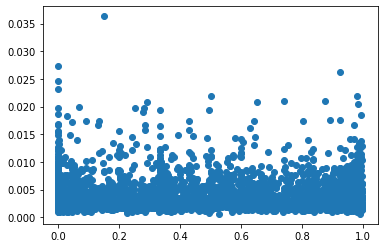

In [20]:
plt.scatter(temp['oimb'], temp['target'])

In [70]:
merged['to_group'] = merged['size'] // 1000

In [76]:
merged['diff'] = (merged['answer'] - merged['target'])

<AxesSubplot:xlabel='to_group'>

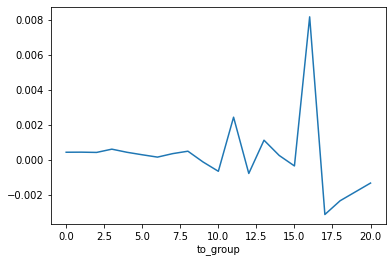

In [77]:
merged.groupby('to_group')['diff'].mean().plot()

In [113]:
temp = pd.pivot_table(book, values='square_return', columns='seconds_in_bucket', index='time_id', aggfunc='last')

<AxesSubplot:xlabel='seconds_in_bucket'>

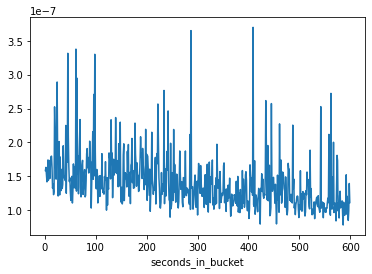

In [116]:
temp.mean().plot()

In [140]:
stock_ids[102]

115

In [141]:
stock_id = stock_ids[102]
book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
trades = pd.read_parquet('trade_train.parquet/stock_id=' + str(stock_id))
book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
book['log_price'] = np.log(book['wap'])
book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
book['square_return'] = book['log_return'] ** 2
book = book[~book['log_return'].isnull()]
book['stock_id'] = stock_id
book = pd.merge(book, trades, on=['time_id', 'seconds_in_bucket'], how='left')

<AxesSubplot:xlabel='seconds_in_bucket'>

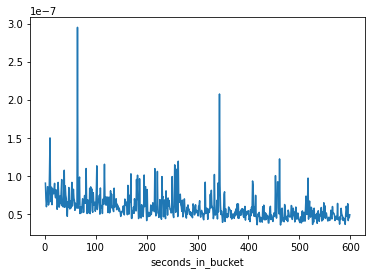

In [145]:
temp = pd.pivot_table(book, values='square_return', columns='seconds_in_bucket', index='time_id', aggfunc='last')
temp.mean().plot()

8149